In [33]:
#changing the working directory

%cd /content/drive/MyDrive/Kaggle/Forest-Cover-Type-Prediction/

/content/drive/MyDrive/Kaggle/Forest-Cover-Type-Prediction


In [34]:
# imports
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

In [63]:
# preprocessing methods

soils_cols = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']
area_cols = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4']
       
def preprocess_forest_data(df):
  def get_soil(row):
    for c in soils_df.columns:
      if row[c]==1:
        return int(c.replace("Soil_Type", ""))
  def get_area(row):
    for c in area_df.columns:
      if row[c]==1:
        return int(c.replace("Wilderness_Area", ""))

  print("Compressing soils data...")
  soils_df = df[soils_cols]
  soils_series = soils_df.apply(get_soil, axis=1)
  df['Soil_Type'] = soils_series
  df = df.drop(soils_cols, axis=1)

  print("Compressing area data...")
  area_df = df[area_cols]
  area_series = area_df.apply(get_area, axis=1)
  df['Wilderness_Area'] = area_series
  df = df.drop(area_cols, axis=1)

  # extract & drop IDs
  ids = df['Id']
  df = df.drop(columns=['Id'])

  print("Adding PCA features...")
  df_scaled = (df- df.mean(axis=0)) / df.std(axis=0)
  pca = PCA()
  df_pca = pca.fit_transform(df_scaled)
  component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
  df_pca = pd.DataFrame(df_pca, columns=component_names)
  df["PC1"] = df_pca["PC1"]
  df["PC5"] = df_pca["PC5"]

  # drop low information columns
  df = df.drop(["Vertical_Distance_To_Hydrology", "Aspect", "Slope", "Hillshade_3pm", "Hillshade_Noon"], axis=1)
  return df

In [95]:
# ploting helpers

cm_plot_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(title)

## Process train set

In [64]:
train_data_path = "train.csv"

forest_data = pd.read_csv(train_data_path)
forest_data

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,1282,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,121,19,633,195,618,249,221,91,1325,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,134,25,365,117,335,250,220,83,1187,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,167,28,218,101,242,229,237,119,932,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [65]:
X = forest_data.copy()
y = X.pop("Cover_Type")

X = preprocess_forest_data(X)
X

Compressing soils data...
Compressing area data...
Adding PCA features...


,Elevation,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area,PC1,PC5
0,2596,258,510,221,6279,29,1,2.477160,2.349859
1,2590,212,390,220,6225,29,1,2.443291,2.264236
2,2804,268,3180,234,6121,12,1,2.788295,3.583020
3,2785,242,3090,238,6211,30,1,3.022746,3.116338
4,2595,153,391,220,6172,29,1,2.358213,2.230608
...,...,...,...,...,...,...,...,...,...
15115,2607,258,660,170,1282,4,3,-0.735746,0.259090
15116,2603,633,618,249,1325,4,3,-0.830528,0.725291
15117,2492,365,335,250,1187,4,3,-1.613414,0.500129
15118,2487,218,242,229,932,4,3,-1.698264,0.286242


## Process submission test set

In [66]:
test_data_path = "test.csv"
test_set = pd.read_csv(test_data_path)
test_set

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565887,581008,2396,153,20,85,17,108,240,237,118,837,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565888,581009,2391,152,19,67,12,95,240,237,119,845,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565889,581010,2386,159,17,60,7,90,236,241,130,854,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565890,581011,2384,170,15,60,5,90,230,245,143,864,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
processed_test_set = preprocess_forest_data(test_set)
processed_test_set

Compressing soils data...
Compressing area data...
Adding PCA features...


,Elevation,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area,PC1,PC5
0,2680,0,2684,196,6645,29,1,-0.581266,1.445021
1,2683,0,2654,201,6675,29,1,-1.585880,1.647809
2,2713,0,2980,206,6344,29,1,-1.619453,1.448532
3,2709,0,2950,208,6374,29,1,-1.579659,1.407863
4,2706,0,2920,210,6404,29,1,-1.540727,1.373304
...,...,...,...,...,...,...,...,...,...
565887,2396,85,108,240,837,2,3,2.130164,0.702718
565888,2391,67,95,240,845,2,3,2.089216,0.663545
565889,2386,60,90,236,854,2,3,2.121597,0.670026
565890,2384,60,90,230,864,2,3,2.205713,0.701379


# Random Forest Classifier

In [88]:
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, stratify=y, random_state=0)

In [89]:
model_random_forest = RandomForestClassifier(n_estimators=1000, random_state=0)

In [ ]:
scores = cross_val_score(model_random_forest, X_train_RF, y_train_RF, scoring='accuracy', cv=5, verbose=2)
print(scores.mean())

In [90]:
model_random_forest.fit(X_train_RF, y_train_RF)
pred_random_forest = model_random_forest.predict(X_test_RF)

# XGBoost

In [83]:
pipeline_xgb = Pipeline(
    steps=[("scale", StandardScaler())]
)
num_cols = X.select_dtypes(include="number").columns
num_cols

Index(['Elevation', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type', 'Wilderness_Area',
       'PC1', 'PC5'],
      dtype='object')

In [91]:
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", pipeline_xgb, num_cols)
    ]
)

X_processed_XGB = full_processor.fit_transform(X)
y_processed_XGB = y.values.reshape(-1, 1)

In [92]:
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(
    X_processed_XGB, y_processed_XGB, stratify=y_processed_XGB, random_state=0
)

In [93]:
model_XGB = XGBClassifier(n_estimators=1000, learning_rate=0.05)

In [ ]:
scores = cross_val_score(model_XGB, X_train_XGB, y_train_XGB, scoring='accuracy', cv=5, verbose=2)
print(scores.mean())

In [ ]:
model_XGB.fit(X_train_XGB, y_train_XGB)
pred_XGB = model_XGB.predict(X_test_XGB)

# Comparing Random Forest to XGBoost

In [96]:
cm_RF = confusion_matrix(y_true=y_test_RF, y_pred=pred_random_forest)
cm_XGB = confusion_matrix(y_true=y_test_XGB, y_pred=pred_XGB)

print("Random Forest: "+ str(accuracy_score(y_test_RF, pred_random_forest)))
print("XGBoost: "+ str(accuracy_score(y_test_XGB, pred_XGB)))

Random Forest: 0.8661375661375661
XGBoost: 0.819047619047619


In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(title)

Confusion matrix, without normalization
[[411  74   1   0  12   1  41]
 [102 359  15   0  43  20   1]
 [  0   3 453  18  13  53   0]
 [  0   0  15 521   0   4   0]
 [  1   6   6   0 522   5   0]
 [  0   1  46  13   4 476   0]
 [  8   0   0   0   0   0 532]]


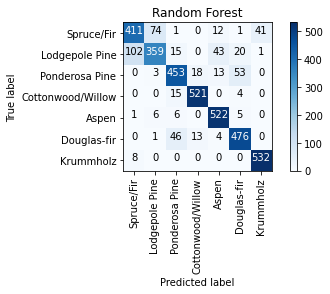

In [97]:
plot_confusion_matrix(cm=cm_RF, classes=cm_plot_labels, title="Random Forest")

Confusion matrix, without normalization
[[375  94   1   0  16   2  52]
 [112 324  14   0  64  25   1]
 [  0   3 416  19  11  91   0]
 [  0   0  18 512   0  10   0]
 [  2  11   8   0 510   9   0]
 [  0   1  87  13   8 431   0]
 [  9   3   0   0   0   0 528]]


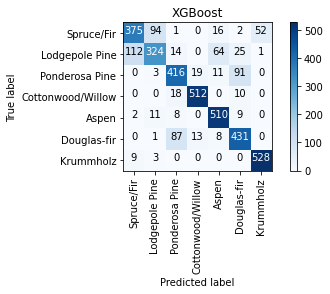

In [98]:
plot_confusion_matrix(cm=cm_XGB, classes=cm_plot_labels, title="XGBoost")

## Apply Random Forest model to submission dataset

In [ ]:
pred_submission = model_random_forest.predict(test_set)
pred_submission

array([2, 2, 2, ..., 3, 3, 3])

In [ ]:
submission_df = pd.DataFrame(
    {
        'Id': test_ids.values,
        'Cover_Type': pred_submission
    },
    columns=['Id', 'Cover_Type']
)
submission_df

,Id,Cover_Type
0,15121,2
1,15122,2
2,15123,2
3,15124,2
4,15125,2
...,...,...
565887,581008,3
565888,581009,3
565889,581010,3
565890,581011,3


In [ ]:
submission_df.to_csv('submission.csv', index=False)
